In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from os.path import join, dirname, abspath
import catboost as cb

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


# PCA 95

In [170]:
metadata = pd.read_csv(join('..', 'Data', 'metadata.csv')).dropna()
metadata['sample_id'] = metadata['sample_id'].apply(lambda x: str(x).replace('.', '-'))
metadata
metadata.set_index('sample_id', inplace = True)
pca_fold = pd.read_csv(join('..', 'Data', 'PCA_95_logfold.csv'), index_col = 0)

### Combine metadata and PCA results
metadata_things = metadata[['sex', 'age', 'type_person', 'diagnosis', 'appendectomy', 'smoking']]

concat_pca_meta = pd.concat([metadata_things, pca_fold], axis = 1)

## RF

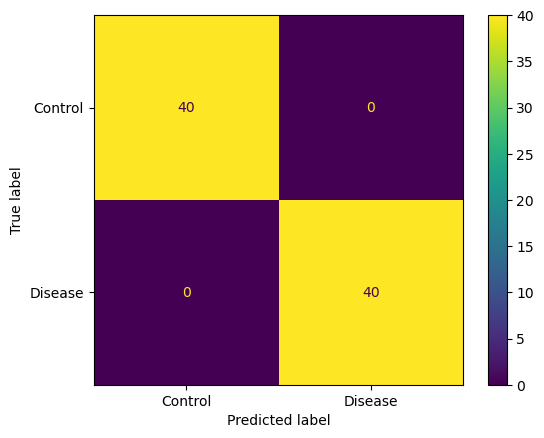

In [185]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, LeavePOut
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
columns = concat_pca_meta.columns
pcs = [col for col in columns if 'PC' in col]

### 
X = concat_pca_meta[pcs]
y = concat_pca_meta['type_person']


clf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')
X_scaled = StandardScaler().fit_transform(X)
clf.fit(X_scaled, y)
y_pred_rf = clf.predict(X_scaled)

cm_rf = confusion_matrix(y, y_pred_rf, labels=clf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=clf.classes_).plot()

/var/folders/zv/p838yyl57rb2tlk802d5y2hh0000gn/T/ipykernel_44170/639516805.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_20['type_person'] = concat_pca_meta['type_person']


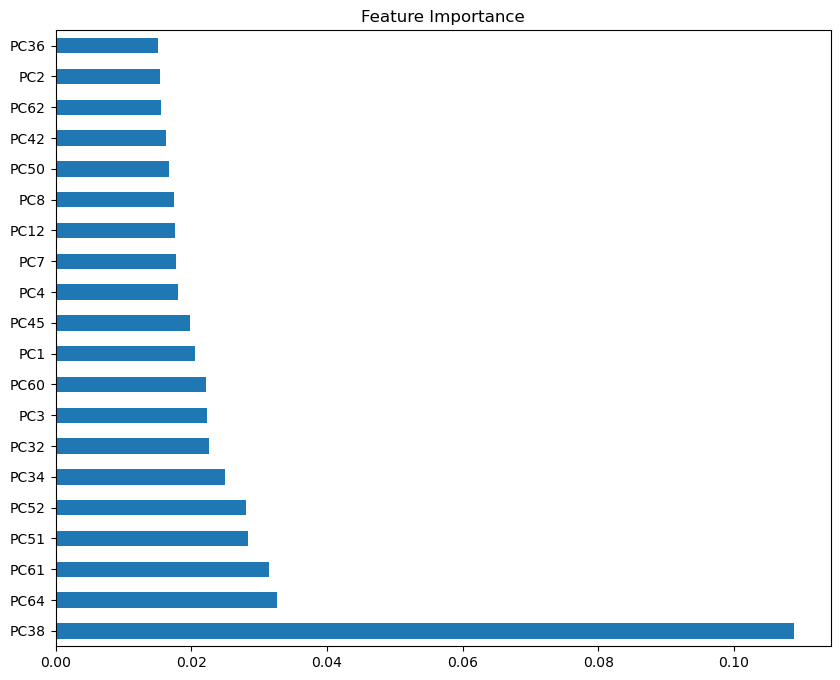

In [191]:
feature_imp = clf.feature_importances_
feature_imp_pd = pd.Series(feature_imp, index=X.columns)
feature_imp_pd.sort_values(ascending=False, inplace=True)
feature_imp_pd.head(20).plot(kind='barh', figsize=(10, 8), title='Feature Importance')  

feature_imp_pd.head(20).index
pd_20 = concat_pca_meta[feature_imp_pd.head(20).index]
pd_20['type_person'] = concat_pca_meta['type_person']

In [192]:
pd_20_X = pd_20.iloc[:, :-1]
pd_20_y = pd_20['type_person']

scores = []
loo = LeaveOneOut()
for train_index, test_index in loo.split(pd_20_X):
    X_train, X_test = pd_20_X.iloc[train_index], pd_20_X.iloc[test_index]
    y_train, y_test = pd_20_y.iloc[train_index], pd_20_y.iloc[test_index]
    
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)
print(f'Accuracy: {np.mean(scores):.2f} ± {np.std(scores):.2f}')

Accuracy: 0.72 ± 0.45


(array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

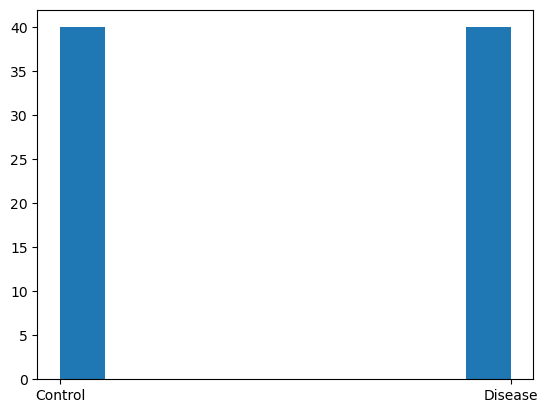

In [188]:
plt.hist(y)

In [189]:
loo = LeavePOut(p = 1)
scores = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = RandomForestClassifier(n_estimators=100, random_state=42,
                                 criterion='entropy')
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)
print(f'Accuracy: {np.mean(scores):.2f} ± {np.std(scores):.2f}')

Accuracy: 0.57 ± 0.49


(array([47.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., 33.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

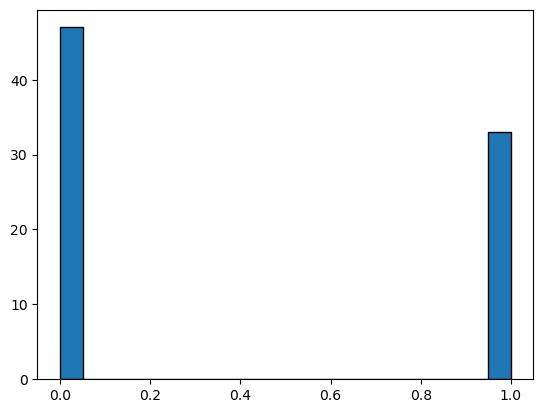

In [147]:
plt.hist(scores, bins=20, edgecolor='black')

## SVM

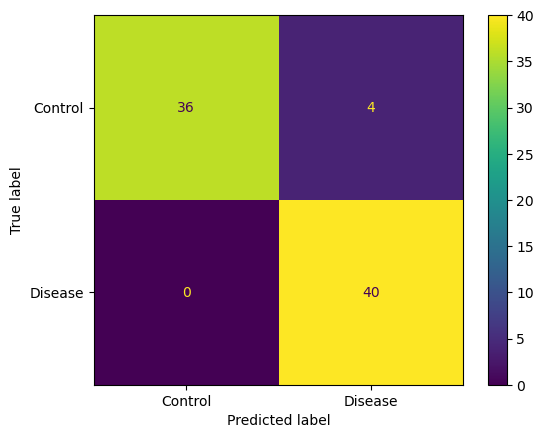

In [148]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

svc = SVC(kernel='rbf', random_state=42)

columns = concat_pca_meta.columns
pcs = [col for col in columns if 'PC' in col]
### 
X = concat_pca_meta[pcs]
y = concat_pca_meta['type_person']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clf = svc.fit(X_scaled, y)
y_pred = clf.predict(X_scaled)
clf.score(X_scaled, y)

cm = confusion_matrix(y, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()

Average score: 0.56, std 0.50


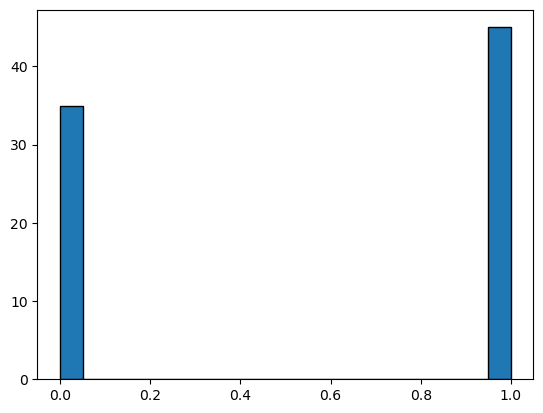

In [138]:
loo = LeavePOut(p = 1)
scores = []
for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = SVC(kernel='rbf', random_state=42)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)    
plt.hist(scores, bins=20, edgecolor='black')
print(f'Average score: {np.mean(scores):.2f}, std {np.std(scores):.2f}')

## Kmeans

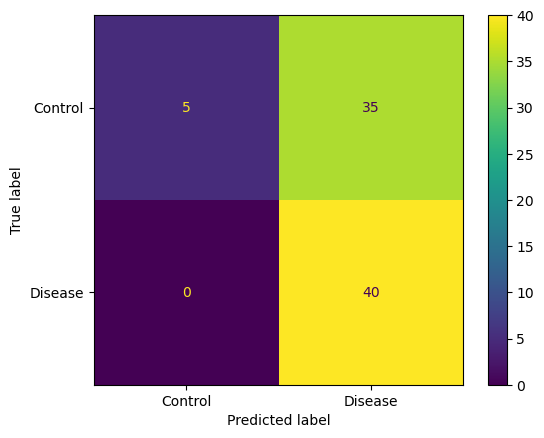

In [139]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_scaled, y)
y_pred_knn = knn.predict(X_scaled)
cm_knn = confusion_matrix(y, y_pred_knn, labels=knn.classes_)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_).plot()

## GP

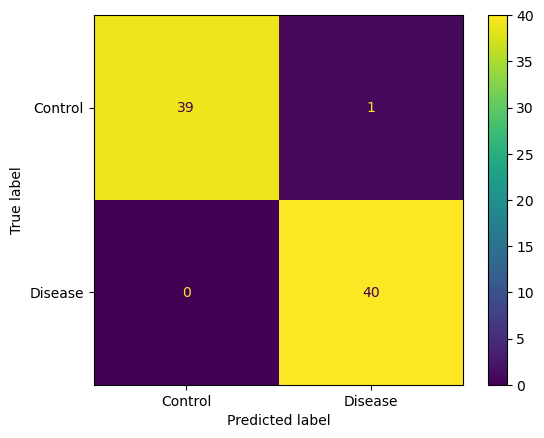

In [140]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
kernel = RBF(length_scale=1.0)
gp = GaussianProcessClassifier(kernel=kernel)
gp.fit(X_scaled, y)
y_pred_gp = gp.predict(X_scaled)
cm_gp = confusion_matrix(y, y_pred_gp, labels=gp.classes_)
disp_gp = ConfusionMatrixDisplay(confusion_matrix=cm_gp, display_labels=gp.classes_).plot()



Average score: 0.53, std 0.50


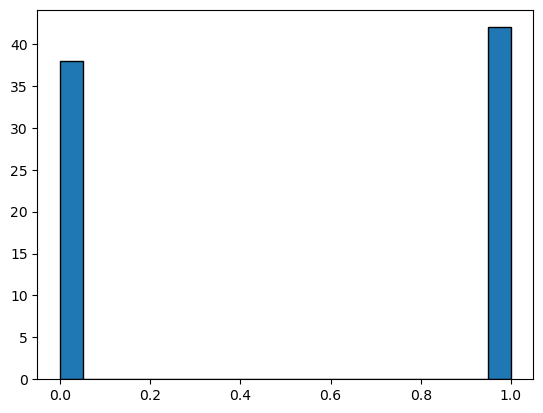

In [141]:
loo = LeavePOut(p = 1)
scores = []
for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = GaussianProcessClassifier(kernel=kernel)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)
plt.hist(scores, bins=20, edgecolor='black')
print(f'Average score: {np.mean(scores):.2f}, std {np.std(scores):.2f}')

# LogFold Data

## RF

In [ ]:
metadata = pd.read_csv(join('..', 'Data', 'metadata.csv')).dropna()
metadata['sample_id'] = metadata['sample_id'].apply(lambda x: str(x).replace('.', '-'))
metadata
metadata.set_index('sample_id', inplace = True)
log_fold = pd.read_csv(join('..', 'Data', 'fold_log.csv'), index_col = 0)

### Combine metadata and PCA results
metadata_things = metadata[['sex', 'age', 'type_person', 'diagnosis', 'appendectomy', 'smoking']]

concat_log_meta = pd.concat([metadata_things, log_fold], axis = 1)

X = concat_log_meta.iloc[:, 6:]
y = concat_log_meta['type_person']





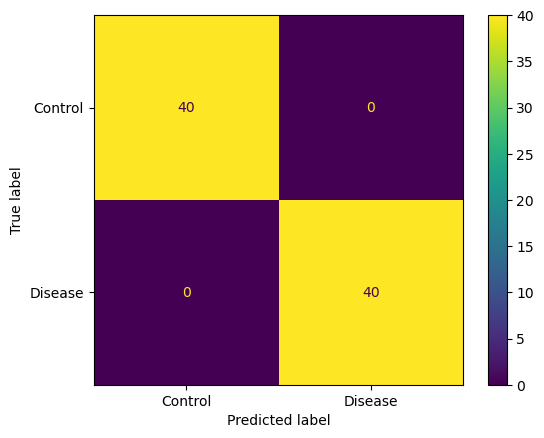

In [159]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')
X_scaled = StandardScaler().fit_transform(X)
clf.fit(X_scaled, y)
y_pred = clf.predict(X_scaled)
cm = confusion_matrix(y, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()



In [160]:
feature_imp = clf.feature_importances_


/var/folders/zv/p838yyl57rb2tlk802d5y2hh0000gn/T/ipykernel_44170/3880862235.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_20['type_person'] = concat_log_meta['type_person']


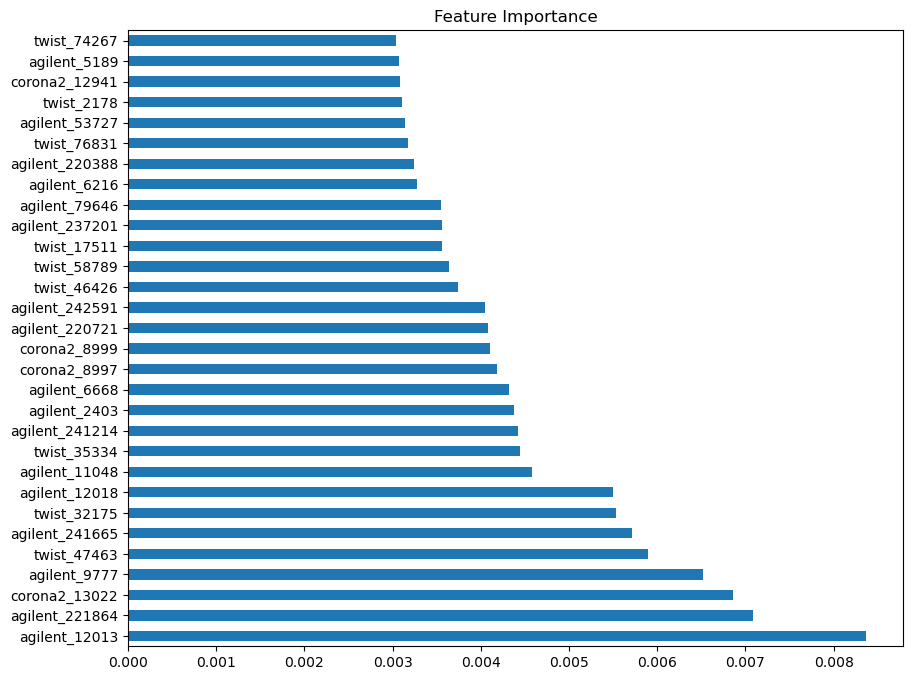

In [161]:
feature_imp = clf.feature_importances_
feature_imp_pd = pd.Series(feature_imp, index=X.columns)
feature_imp_pd.sort_values(ascending=False, inplace=True)
feature_imp_pd.head(30).plot(kind='barh', figsize=(10, 8), title='Feature Importance')

veinte_best = feature_imp_pd.head(30).index
pd_20 = concat_log_meta[veinte_best]
pd_20['type_person'] = concat_log_meta['type_person']

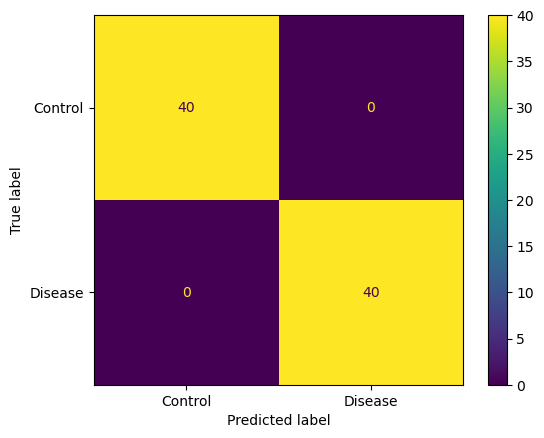

In [162]:
X = pd_20.iloc[:, :-1]
y = pd_20['type_person']
clf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')    
X_scaled = StandardScaler().fit_transform(X)
clf.fit(X_scaled, y)
y_pred_rf = clf.predict(X_scaled)
cm_rf = confusion_matrix(y, y_pred_rf, labels=clf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=clf.classes_).plot()

Average score: 0.72, std 0.45


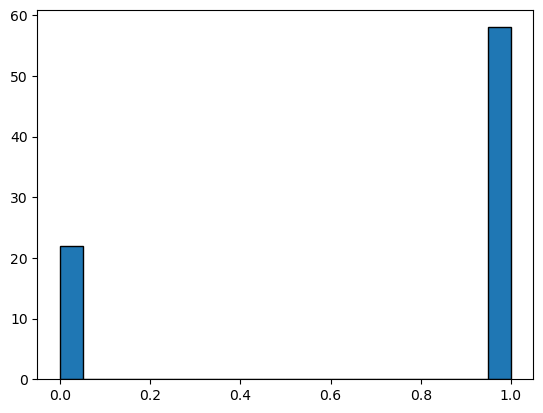

In [163]:
loo = LeavePOut(p = 1)
scores = []
for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)
    
plt.hist(scores, bins=20, edgecolor='black')
print(f'Average score: {np.mean(scores):.2f}, std {np.std(scores):.2f}')

Average score: 0.54, std 0.50


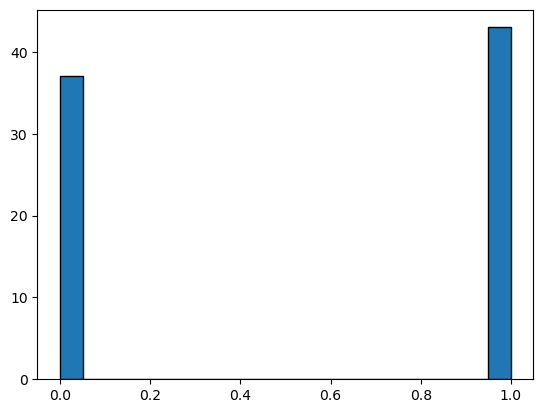

In [84]:
loo = LeavePOut(p = 1)
scores = []
for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)
    
plt.hist(scores, bins=20, edgecolor='black')
print(f'Average score: {np.mean(scores):.2f}, std {np.std(scores):.2f}')

## SVM

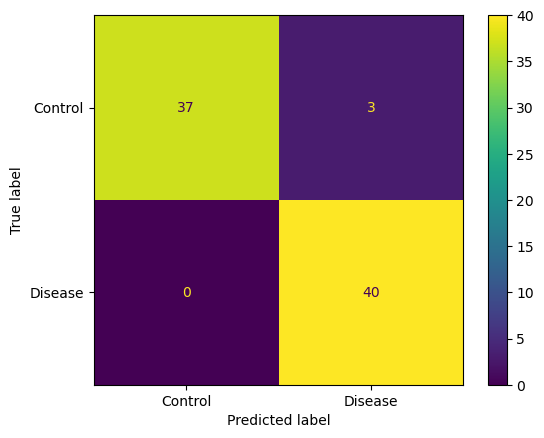

In [86]:
clf = SVC(kernel='rbf', random_state=42)
X_scaled = StandardScaler().fit_transform(X)
clf.fit(X_scaled, y)
y_pred = clf.predict(X_scaled)
cm = confusion_matrix(y, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()

Average score: 0.49, std 0.50


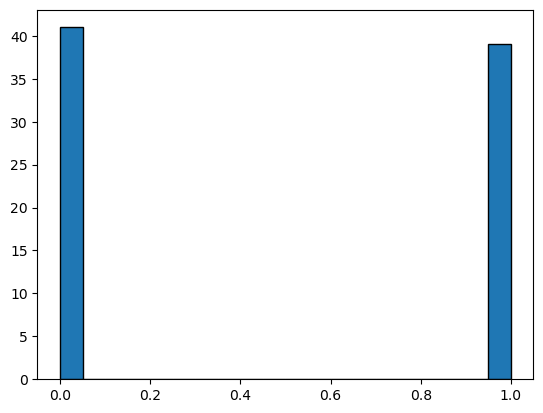

In [87]:
loo = LeavePOut(p = 1)
scores = []
for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = SVC(kernel='rbf', random_state=42)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)
plt.hist(scores, bins=20, edgecolor='black')
print(f'Average score: {np.mean(scores):.2f}, std {np.std(scores):.2f}')

## Kmeans

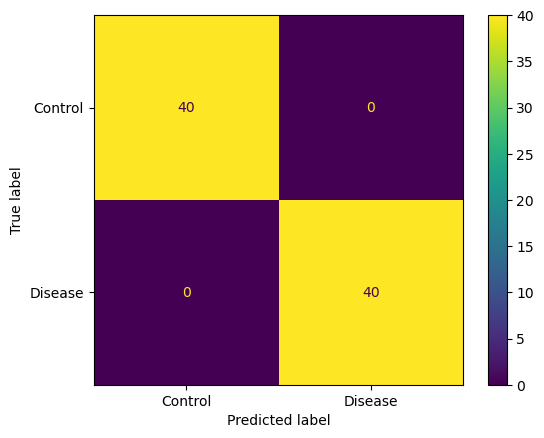

In [89]:
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_scaled, y)
y_pred_knn = clf.predict(X_scaled)
cm_knn = confusion_matrix(y, y_pred_knn, labels=clf.classes_)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=clf.classes_).plot()  


Average score: 0.50, std 0.50


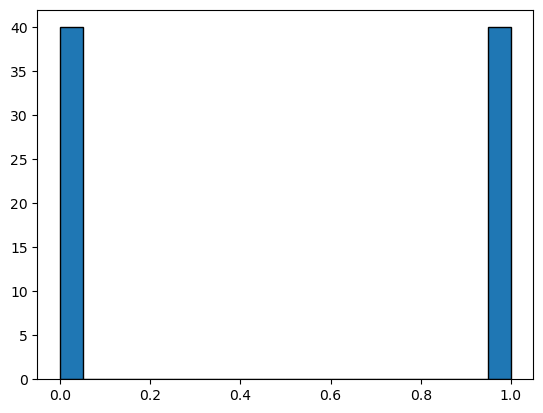

In [90]:
loo = LeavePOut(p = 1)
scores = []
for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = KNeighborsClassifier(n_neighbors=2)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)
plt.hist(scores, bins=20, edgecolor='black')
print(f'Average score: {np.mean(scores):.2f}, std {np.std(scores):.2f}')

## GP

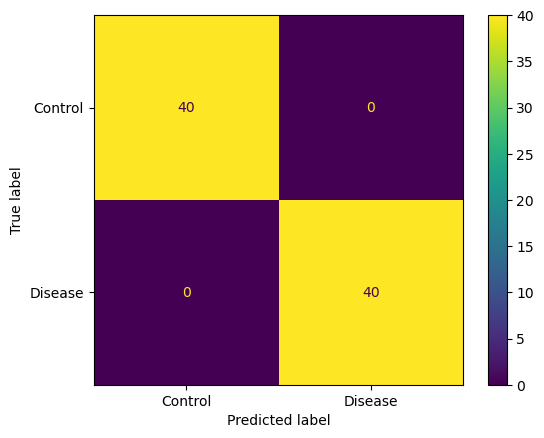

In [91]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')
clf.fit(X_scaled, y)
y_pred_rf = clf.predict(X_scaled)
cm_rf = confusion_matrix(y, y_pred_rf, labels=clf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=clf.classes_).plot()

Average score: 0.50, std 0.50


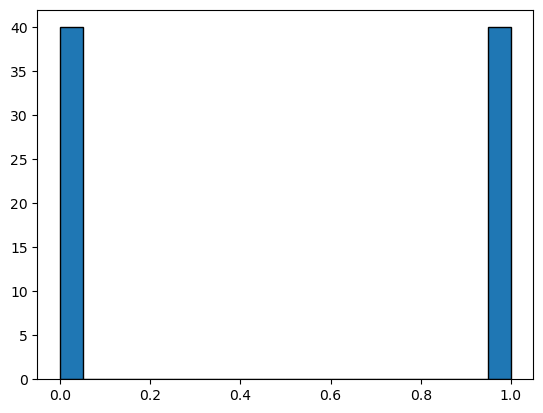

In [92]:
loo = LeavePOut(p = 1)
scores = []
for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = GaussianProcessClassifier(kernel=kernel)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)
plt.hist(scores, bins=20, edgecolor='black')
print(f'Average score: {np.mean(scores):.2f}, std {np.std(scores):.2f}')